![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

# HACER UN DESCRIPTIVO DEL CONJUNTO DE DATOS

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

Este conjunto de datos fue provisto por profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

# Exploración y análisis de datos

## Importar librerias
Estas son las librerías que se van a usar para todo el análisis

In [4]:
# Importación librerías
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

from joblib import dump, load
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score


from keras.callbacks import EarlyStopping, ModelCheckpoint, ProgbarLogger, CSVLogger
from tensorflow.keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from keras import initializers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from livelossplot import PlotLossesKeras
from keras import backend as K
import keras.optimizers as opts

import re
from sklearn.model_selection import GridSearchCV

import re
from unidecode import unidecode

# Descargar módulo stop words de NLTK
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\calda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
# Listado de funciones usadas en el proyecto
def split_into_lemmas(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word, pos="v") for word in words]

def preprocesamiento(texto):
    procesado = texto.lower()
    procesado = re.sub(r"[^a-zÑñ\s]","",procesado)
    procesado = unidecode(procesado)
    procesado = re.sub(r"\s+"," ",procesado)
    wordnet_lemmatizer = WordNetLemmatizer()
    procesado = [wordnet_lemmatizer.lemmatize(i, pos="v") for i in procesado.split() if len(i)>3 and i not in stopwords.words("english")] #lematizar verbos
    procesado = " ".join(procesado)
    procesado = [wordnet_lemmatizer.lemmatize(i, pos="n") for i in procesado.split()] #Plurales
    # " ".join(procesado)
    return procesado

# texto =  "most is the STORY of a single father who takes his eight year - olds son to work with him at the railroad drawbridge where he is the bridge tender"
# preprocesamiento(texto)


In [37]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('../DATA/dataTraining.csv', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('../DATA/dataTesting.csv', encoding='UTF-8', index_col=0)

In [38]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [39]:
# Visualización datos de test
display(dataTesting.iloc[666][2])

display(dataTesting.iloc[508][2])

"john singleton ' s portrayal of social problems in inner - city los angeles takes the form of a tale of three friends growing up together  ' in the  ' hood .  '  half - brothers doughboy and ricky baker are foils for each other ' s personality ,  presenting very different approaches to the tough lives they face .  ricky is the  ' all - american '  athlete ,  looking to win a football scholarship to usc and seeks salvation through sports ,  while  ' dough '  succumbs to the violence ,  alcohol ,  and crime surrounding him in his environment ,  but maintains a strong sense of pride and code of honor .  between these two is their friend tre ,  who is lucky to have a father ,   ' furious '  styles ,  to teach him to have the strength of character to do what is right and to always take responsibility for his actions ."

'when we go to sleep ,  two forces battle for our dreams :  the storytellers ,  who give us good dreams ;  and the incubi ,  who give us nightmares .  widower john sullivan is estranged from his young daughter emma ,  having been deemed unable to care for her .  now on the edge of a huge investment deal with a major corporation ,  he is unaware that he is being stalked by an incubus .  and on the city outskirts ,  a mysterious stranger named ink snatches little emma from her bed and escapes into the dream world ,  intent on selling her soul to the assembly of the incubi so that he may be allowed entry into their ranks .  a small band of storytellers realizes that the only way to save emma is to reunite her with her father in the physical world ,  and they will do anything to make sure that this comes to pass .'

## Modelo base - información inicial

Este modelo es el ejemplo para estructurar la información de la competencia

In [40]:
# Definición de variables predictoras (X)
vect = CountVectorizer(max_features=1000)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

#dump(vect, '../OUTPUT/MODELS/modelo_base_cv.bin', compress=True)


(7895, 1000)

In [41]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

#dump(le, '../OUTPUT/MODELS/modelo_base_le.bin', compress=True)


In [42]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

# Definición y entrenamiento
# clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
# clf.fit(X_train, y_train_genres)

# # Predicción del modelo de clasificación
# y_pred_genres = clf.predict_proba(X_test)

# # Impresión del desempeño del modelo
# display("Desemepeño por la medida macro",roc_auc_score(y_test_genres, y_pred_genres, average='macro'))

# # transformación variables predictoras X del conjunto de test
# X_test_dtm = vect.transform(dataTesting['plot'])

# # Predicción del conjunto de test
# y_pred_test_genres = clf.predict_proba(X_test_dtm)

# dump(clf, '../OUTPUT/MODELS/modelo_base.bin', compress=True)


In [43]:
X_test[0]

<1x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 26 stored elements in Compressed Sparse Row format>

# Modelo 1

Este modelo va a usar el procesamiento de texto stemming con TF-IDF, y los valores por defecto un Ramom Forest. La idea es analizar el desempeño base y partir de este, empezar a considerar modelos altervativos que superen este valor de prediccion.

In [13]:
# Diccionarios para guardar las metricas de los modelos
# X_train, X_test, y_train_genres, y_test_genres
dict_score = {}
validacion_cruzada = {}
dataTraining = pd.read_csv('../DATA/dataTraining.csv', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('../DATA/dataTesting.csv', encoding='UTF-8', index_col=0)

#token_pattern = re.compile("w+")
cv = CountVectorizer( lowercase = True, ngram_range=(3,3),analyzer=preprocesamiento, stop_words="english") #, , 
X_dtm = cv.fit_transform(dataTraining['plot'])
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)


In [44]:
dims = X_test.shape[1]
output_var = y_train_genres.shape[1]

# Modelo 2. Redes Neuronales 

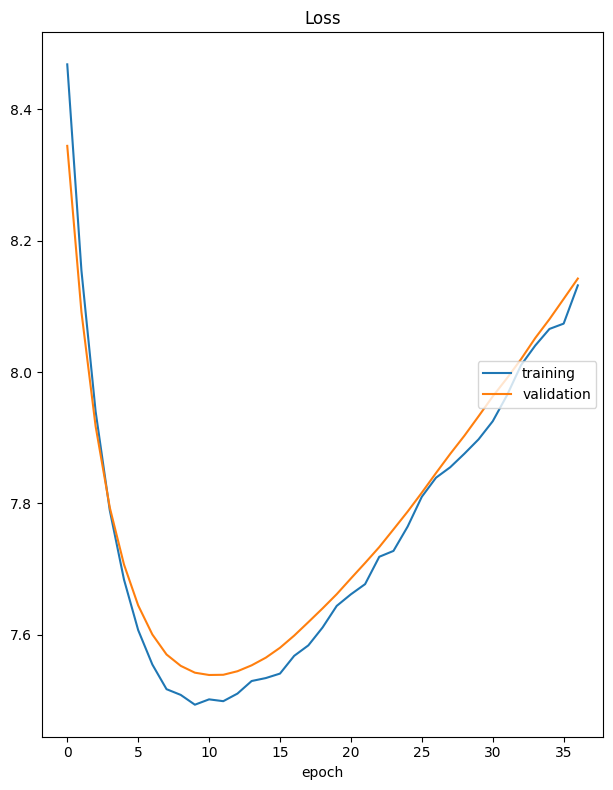

Loss
	training         	 (min:    7.493, max:    8.468, cur:    8.132)
	validation       	 (min:    7.539, max:    8.344, cur:    8.142)
166/166 [==============================] - 4s 22ms/step - loss: 8.1319 - val_loss: 8.1423
Epoch 38/200
166/166 [==============================] - ETA: 0s - loss: 8.1149

KeyboardInterrupt: 

In [60]:
K.clear_session()

# Definición red neuronal con la función Sequential()
model = Sequential()

# Definición de la capa densa con un tamaño de salida igual a output_var y un input_shape de dims
model.add(Dense(32, input_shape=(dims,),activation='sigmoid'))
model.add(Dense(128,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(256,activation='sigmoid'))
model.add(Dense(256,activation='sigmoid'))
model.add(Dense(256,activation='softmax'))
model.add(Dense(256,activation='softmax'))
model.add(Dense(256,activation='softmax'))
model.add(Dense(128,activation='softmax'))
model.add(Dense(128,activation='softmax'))
model.add(Dense(32,activation='softmax'))
model.add(Dense(16,activation='softmax'))
model.add(Dropout(0.2))
model.add(Dense(output_var))
model.add(Activation('softmax'))
model.compile(optimizer='RMSprop', loss='categorical_crossentropy')
# Entrenamiento de la red neuronal con 50 épocas
model.fit(X_train.todense(), y_train_genres, 
          verbose=1, 
          epochs=200, 
          validation_data=(X_test.todense(), y_test_genres),
          callbacks=[PlotLossesKeras()])

# Impresión de la arquitectura de la red neuronal
print(model.summary())
dict_score['Multicapa MSE'] = model.get_metrics_result()['loss'].numpy()

#dump(model, '../OUTPUT/MODELS/RN_base_DG.bin', compress=True)


In [26]:
# Obtener las predicciones del conjunto de prueba
y_pred_proba = model.predict(X_test.todense())
display("Desempeño por la medida macro",roc_auc_score(y_test_genres, y_pred_proba, average='macro'))

82/82 [==============================] - 0s 1ms/step


'Desempeño por la medida macro'

0.5071828409102903

In [13]:
def nn_model_params(optimizer ,
                    neurons,
                    batch_size,
                    epochs,
                    activation,
                    patience,
                    loss):
    K.clear_session()
    model = Sequential()   
    model.add(Dense(neurons, input_shape=(dims,), activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(output_var, activation=activation))
    model.compile(optimizer = optimizer, loss=loss)
    early_stopping = EarlyStopping(monitor="val_loss", patience = patience)
    model.fit(X_train.todense(), y_train_genres,
              validation_data = (X_test.todense(), y_test_genres),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[early_stopping, PlotLossesKeras()],
              verbose=True
              )
     
    return model

nn_params = {
    'optimizer': ['adam','sgd','RMSprop'],
    'activation': ['sigmoid','softmax'],
    'batch_size': [64,128],
    'neurons':[64,128,256],
    'epochs':[20,50,150],
    'patience':[2,5],
    'loss':['mean_squared_error','categorical_crossentropy']
}

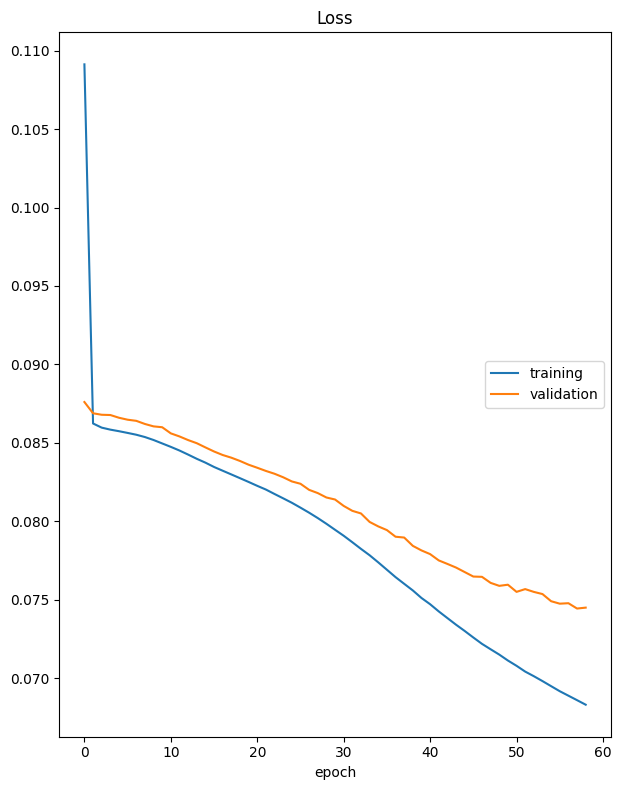

Loss
	training         	 (min:    0.068, max:    0.109, cur:    0.068)
	validation       	 (min:    0.074, max:    0.088, cur:    0.075)
83/83 [==============================] - 1s 9ms/step - loss: 0.0683 - val_loss: 0.0745
Epoch 60/150
56/83 [===================>..........] - ETA: 0s - loss: 0.0684

In [34]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

nn_model = KerasClassifier(build_fn=nn_model_params, verbose=0)

rs = GridSearchCV(nn_model, nn_params, cv=5)

rs.fit(X_train.todense(), y_train_genres)

print('Los mejores parametros segun Randomnized Search:', rs.best_params_)

In [31]:

print('Los mejores parametros segun Randomnized Search:', rs.best_params_)

Los mejores parametros segun Randomnized Search: {'patience': 5, 'optimizer': 'adam', 'neurons': 128, 'loss': 'categorical_crossentropy', 'epochs': 50, 'batch_size': 128, 'activation': 'sigmoid'}


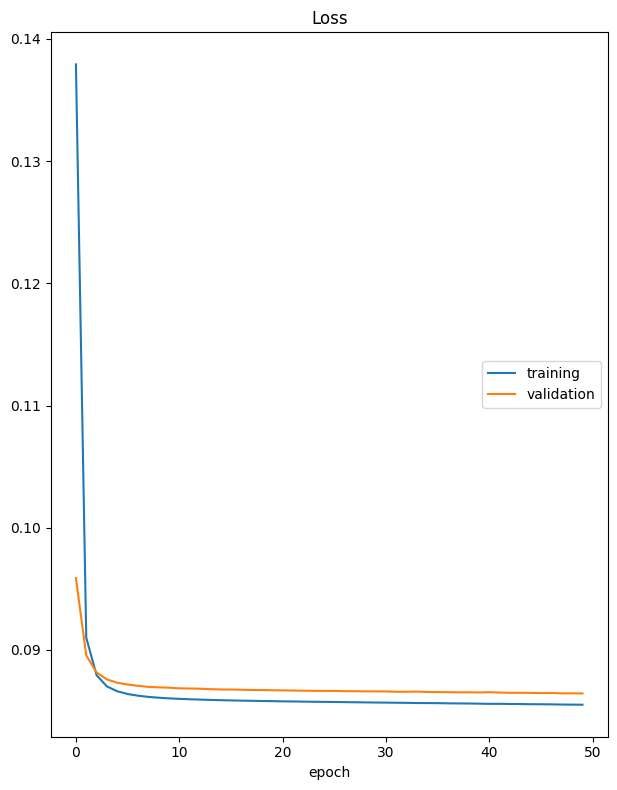

Loss
	training         	 (min:    0.086, max:    0.138, cur:    0.086)
	validation       	 (min:    0.086, max:    0.096, cur:    0.086)
82/82 [==============================] - 0s 1ms/step


'Desempeño por la medida macro'

0.5306735708063988

In [51]:
# Obtener las predicciones del conjunto de prueba
# model = nn_model_params(optimizer = 'adam',
#                         neurons=64,
#                         batch_size=128,
#                         epochs=20,
#                         activation='sigmoid',
#                         patience=2,
#                         loss='mean_squared_error')
#0.6352618445325292

model = nn_model_params(optimizer = 'sgd',
                        neurons=256,
                        batch_size=8,
                        epochs=50,
                        activation='sigmoid',
                        patience=10,
                        loss='mean_squared_error')

y_pred_proba = model.predict(X_test.todense())
display("Desempeño por la medida macro",roc_auc_score(y_test_genres, y_pred_proba, average='macro'))

# Salvar resultados para la competencia en Kaggle 

In [ ]:
# Guardar predicciones en formato exigido en la competencia de kaggle
codigo_modelo = "modelo_base_DG"


cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv(f'../OUTPUT/KAGGLE/pred_genres_text_RF{codigo_modelo}.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.143030,0.101960,0.024454,0.029938,0.354552,0.138830,0.030787,0.490140,0.073159,0.101339,...,0.025069,0.063208,0.000000,0.362818,0.056648,0.008970,0.017522,0.202605,0.033989,0.018117
4,0.122624,0.085786,0.024213,0.084795,0.370949,0.216657,0.080359,0.515684,0.062976,0.067019,...,0.024734,0.060935,0.000477,0.149703,0.058190,0.014248,0.020099,0.204794,0.030438,0.018506
5,0.151364,0.110284,0.013762,0.075334,0.304837,0.448736,0.021010,0.611544,0.081741,0.169121,...,0.044538,0.261372,0.000000,0.335987,0.128505,0.001016,0.048658,0.423242,0.052693,0.025351
6,0.154448,0.125772,0.020991,0.064124,0.340779,0.140892,0.009133,0.632038,0.068287,0.063631,...,0.131074,0.088418,0.000000,0.197224,0.132208,0.001432,0.039743,0.269385,0.077607,0.017862
7,0.175143,0.210069,0.035476,0.032505,0.313850,0.243150,0.021793,0.427885,0.079781,0.143879,...,0.023859,0.090359,0.000048,0.205117,0.241663,0.002634,0.018403,0.259465,0.021569,0.017585
